In [1]:
import json
import numpy as np
from preprocess_data.process_ground_truth import reform_ground_truth, ground_truth_sep
import tensorflow as tf
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, recall_score
from hyperopt import hp, fmin, tpe, Trials
from tensorflow.keras.optimizers import Adam
import os

In [2]:
os.chdir(os.path.dirname(os.path.dirname(os.path.abspath('CNN-RNN.ipynb'))))

with open('preprocess_data/lateral_acceleration_data.json', 'r') as f:
    LA_data = json.load(f)
    
with open('preprocess_data/SWA_data.json', 'r') as f:
    SWA_data = json.load(f)

with open('preprocess_data/lateral_displacement_data.json', 'r') as f:
    LD_data = json.load(f)
    
with open('preprocess_data/YA_data.json', 'r') as f:
    YA_data = json.load(f)
    
with open('preprocess_data/ground_truth.json', 'r') as f:
    ground_truth = json.load(f)
    
def time_derivative(data, time_interval):
    data_dt = {}
    for name in data.keys():
        delta_displacement = np.diff(data[name])
        data_dt[name] = np.gradient(delta_displacement, time_interval)
    return data_dt

sample_rate = 100
SWV_data= time_derivative(SWA_data, 1/sample_rate)
YR_data= time_derivative(YA_data, 1/sample_rate)

#standardize the data
def standardize(data):
    data_standard = {}
    for name in data.keys():
        data_standard[name] = (data[name] - np.mean(data[name]))/np.std(data[name])
    return data_standard

YR_standard = standardize(YR_data)
SWA_standard = standardize(SWA_data)
SWV_standard = standardize(SWV_data)
LD_standard = standardize(LD_data)
LA_standard = standardize(LA_data)

#apply the time window
size_= 10
step = 1
ground_truth=reform_ground_truth(ground_truth)
awake_window, light_drowsy_window, drowsy_window=ground_truth_sep(ground_truth,size_,step)

def define_feature_matrix(window, data):
    feature_matrix = []
    for name in window.keys():
        for i in range(len(window[name])):
            begin = window[name][i][0]*sample_rate
            end = (window[name][i][-1]+1)*sample_rate
            feature_matrix.append(data[name][begin:end])
    return np.array(feature_matrix)
    

awake_YR_feature = define_feature_matrix(awake_window, YR_standard)
awake_SWA_feature = define_feature_matrix(awake_window, SWA_standard)
awake_SWV_feature = define_feature_matrix(awake_window, SWV_standard)
awake_LD_feature = define_feature_matrix(awake_window, LD_standard)
awake_LA_feature = define_feature_matrix(awake_window, LA_standard)
awake_feature_matrix=np.dstack((awake_YR_feature, awake_SWA_feature, awake_SWV_feature, awake_LD_feature, awake_LA_feature))
awake_label = np.ones(awake_feature_matrix.shape[0])*0

light_drowsy_YR_feature = define_feature_matrix(light_drowsy_window, YR_standard)
light_drowsy_SWA_feature = define_feature_matrix(light_drowsy_window, SWA_standard)
light_drowsy_SWV_feature = define_feature_matrix(light_drowsy_window, SWV_standard)
light_drowsy_LD_feature = define_feature_matrix(light_drowsy_window, LD_standard)
light_drowsy_LA_feature = define_feature_matrix(light_drowsy_window, LA_standard)
light_drowsy_feature_matrix=np.dstack((light_drowsy_YR_feature, light_drowsy_SWA_feature, light_drowsy_SWV_feature, light_drowsy_LD_feature, light_drowsy_LA_feature))
light_drowsy_label = np.ones(light_drowsy_feature_matrix.shape[0])*1

drowsy_YR_feature = define_feature_matrix(drowsy_window, YR_standard)
drowsy_SWA_feature = define_feature_matrix(drowsy_window, SWA_standard)
drowsy_SWV_feature = define_feature_matrix(drowsy_window, SWV_standard)
drowsy_LD_feature = define_feature_matrix(drowsy_window, LD_standard)
drowsy_LA_feature = define_feature_matrix(drowsy_window, LA_standard)
drowsy_feature_matrix=np.dstack((drowsy_YR_feature, drowsy_SWA_feature, drowsy_SWV_feature, drowsy_LD_feature, drowsy_LA_feature))
drowsy_label=np.ones(drowsy_feature_matrix.shape[0])*2


feature_matrix=np.concatenate((awake_feature_matrix, light_drowsy_feature_matrix, drowsy_feature_matrix), axis=0)
label=np.concatenate((awake_label, light_drowsy_label, drowsy_label), axis=0)
# label=tf.keras.utils.to_categorical(label-1, num_classes=3)
label=label.astype(int)

X_train, X_test, y_train, y_test = train_test_split(feature_matrix, label, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

def make_model(space,best_params):
    Input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    model= tf.keras.models.Sequential([
        Input_layer,
        # filters, kernel_size, activation, input_shape
        tf.keras.layers.Conv1D(space['conv_filters_1'][best_params['conv_filters_1']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        # window size
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_2'][best_params['conv_filters_2']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_3'][best_params['conv_filters_3']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_4'][best_params['conv_filters_4']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=space['learning_rate'][best_params['learning_rate']]), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    return model

def confusion_matrix_on_test_data(model,model_name, X_test, y_test):
    y_pred=[]
    for row in model.predict(X_test):
        y_pred.append(np.argmax(row))
    y_pred=np.array(y_pred)    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 1', 'Class 2', 'Class 3'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix of '+model_name)
    plt.show()

In [3]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / len(awake_label)) * (len(label) / 3.0)
weight_for_1 = (1 / len(light_drowsy_label)) * (len(label) / 3.0)
weight_for_2 = (1 / len(drowsy_label)) * (len(label) / 3.0)
# weight_for_0 = 1
# weight_for_1 = 2
# weight_for_2 = 3


class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}


In [4]:
#define search space
# space = {
#     'conv_filters_1': hp.choice('conv_filters_1', [16, 32, 64, 128]),
#     'conv_filters_2': hp.choice('conv_filters_2', [16, 32, 64, 128]),
#     'conv_filters_3': hp.choice('conv_filters_3', [16, 32, 64, 128]),
#     'conv_filters_4': hp.choice('conv_filters_4', [16, 32, 64, 128]),
#     'mini_batch_size': hp.choice('mini_batch_size', [16, 32, 64, 128]),
#     'learning_rate': hp.uniform('learning_rate', 0.001, 0.01),
#     'pooling_size_hyperopt': hp.choice('pooling_size_hyperopt', [2,3]),
#     'neurons_lstm': hp.choice('neurons_lstm', [16, 32, 64, 128]),
#     'neurons_gru': hp.choice('neurons_gru', [16, 32, 64, 128])
# }
# 
# space_params = {
#     'conv_filters_1': [16, 32, 64, 128],
#     'conv_filters_2': [16, 32, 64, 128],
#     'conv_filters_3': [16, 32, 64, 128],
#     'conv_filters_4': [16, 32, 64, 128],
#     'mini_batch_size': [16, 32, 64, 128],
#     'pooling_size_hyperopt': [2,3],
#     'neurons_lstm': [16, 32, 64, 128],
#     'neurons_gru': [16, 32, 64, 128]
# }
space = {
    'conv_filters_1': hp.choice('conv_filters_1', [32, 64, 128]),
    'conv_filters_2': hp.choice('conv_filters_2', [32, 64, 128]),
    'conv_filters_3': hp.choice('conv_filters_3', [32, 64, 128]),
    'conv_filters_4': hp.choice('conv_filters_4', [32, 64, 128]),
    'mini_batch_size': hp.choice('mini_batch_size', [32, 64, 128]),
    'learning_rate': hp.choice('learning_rate', [0.001, 0.005, 0.01]),
    'pooling_size_hyperopt': hp.choice('pooling_size_hyperopt', [2,3]),
    'neurons_lstm': hp.choice('neurons_lstm', [32, 64, 128]),
    'neurons_gru': hp.choice('neurons_gru', [32, 64, 128])
}

space_params = {
    'conv_filters_1': [32, 64, 128],
    'conv_filters_2': [32, 64, 128],
    'conv_filters_3': [32, 64, 128],
    'conv_filters_4': [32, 64, 128],
    'learning_rate': [0.001, 0.005, 0.01],
    'mini_batch_size': [32, 64, 128],
    'pooling_size_hyperopt': [2,3],
    'neurons_lstm': [32, 64, 128],
    'neurons_gru': [32, 64, 128]
}


In [144]:

def objective(params):
    Input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    model= tf.keras.models.Sequential([
        Input_layer,
        tf.keras.layers.Conv1D(params['conv_filters_1'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_2'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_3'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_4'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    model.fit(X_train, y_train, epochs=50, batch_size=params['mini_batch_size'], validation_data=(X_val, y_val), verbose=0)
    _, val_acc = model.evaluate(X_val, y_val, verbose=0)
    return -val_acc  # Hyperopt minimizes the objective function

trials = Trials()
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=10, trials=trials)

print("Best hyperparameters:", best_params)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



100%|██████████| 10/10 [10:05<00:00, 60.58s/trial, best loss: -0.825941801071167]
Best hyperparameters: {'conv_filters_1': 0, 'conv_filters_2': 2, 'conv_filters_3': 0, 'conv_filters_4': 1, 'learning_rate': 0.004433533487427123, 'mini_batch_size': 1, 'pooling_size_hyperopt': 0}


116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


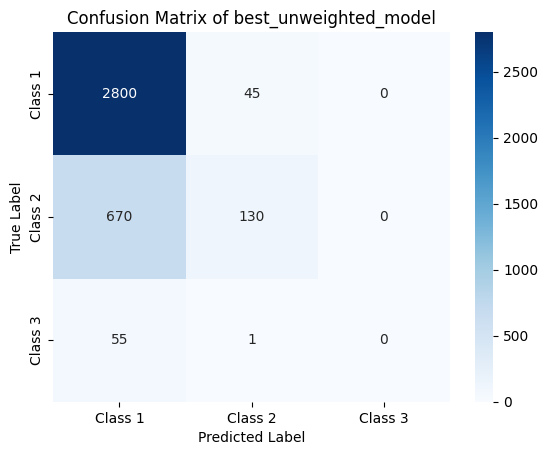

In [145]:
best_unweighted_model = make_model(space_params, best_params)
best_unweighted_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), verbose=0)
confusion_matrix_on_test_data(best_unweighted_model, 'best_unweighted_model', X_test, y_test)

100%|██████████| 5/5 [1:33:45<00:00, 1125.07s/trial, best loss: -0.9225083589553833]
Best hyperparameters: {'conv_filters_1': 1, 'conv_filters_2': 1, 'conv_filters_3': 2, 'conv_filters_4': 0, 'learning_rate': 0, 'mini_batch_size': 0, 'neurons_gru': 0, 'neurons_lstm': 2, 'pooling_size_hyperopt': 0}
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


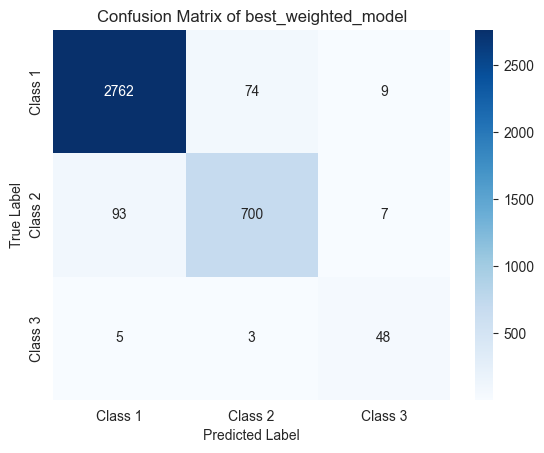

In [5]:
def objective_weighted(params):
    Input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    model= tf.keras.models.Sequential([
        Input_layer,
        tf.keras.layers.Conv1D(params['conv_filters_1'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_2'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_3'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_4'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    model.fit(X_train, y_train, epochs=50, batch_size=params['mini_batch_size'], validation_data=(X_val, y_val), verbose=0, class_weight=class_weight)
    _, val_acc = model.evaluate(X_val, y_val, verbose=0)
    return -val_acc  # Hyperopt minimizes the objective function

trials = Trials()
best_params_weighted = fmin(objective_weighted, space, algo=tpe.suggest, max_evals=5, trials=trials)

print("Best hyperparameters:", best_params_weighted)
best_weighted_model = make_model(space_params, best_params_weighted)
best_weighted_model.fit(X_train, y_train, epochs=50, batch_size=space_params['mini_batch_size'][best_params_weighted['mini_batch_size']], validation_data=(X_val, y_val), verbose=0, class_weight=class_weight)
confusion_matrix_on_test_data(best_weighted_model, 'best_weighted_model', X_test, y_test)

In [ ]:
np.random.seed(42)
selected_awake_cases=len(drowsy_label)
selected_light_drowsy_cases=len(drowsy_label)
selected_awake_indices=np.random.choice(awake_feature_matrix.shape[0], selected_awake_cases, replace=False)
selected_light_drowsy_indices=np.random.choice(light_drowsy_feature_matrix.shape[0], selected_light_drowsy_cases, replace=False)
selected_awake_feature_matrix=awake_feature_matrix[selected_awake_indices]
selected_light_drowsy_feature_matrix=light_drowsy_feature_matrix[selected_light_drowsy_indices]
downsample_feature_matrix=np.concatenate((selected_awake_feature_matrix, selected_light_drowsy_feature_matrix, drowsy_feature_matrix), axis=0)
downsample_label=np.concatenate((np.ones(selected_awake_cases)*0, np.ones(selected_light_drowsy_cases)*1, np.ones(len(drowsy_label))*2), axis=0)
downsample_label=downsample_label.astype(int)

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(downsample_feature_matrix, downsample_label, test_size=0.15, random_state=42)
X_train_d, X_val_d, y_train_d, y_val_d = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [137]:
trials = Trials()
best_params_downsampled = fmin(objective, space, algo=tpe.suggest, max_evals=30, trials=trials)

print("Best hyperparameters:", best_params_downsampled)

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



100%|██████████| 30/30 [18:04<00:00, 36.14s/trial, best loss: -0.8079642057418823]
Best hyperparameters: {'conv_filters_1': 0, 'conv_filters_2': 3, 'conv_filters_3': 2, 'conv_filters_4': 1, 'learning_rate': 0.002375654342871365, 'mini_batch_size': 2, 'pooling_size_hyperopt': 0}


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


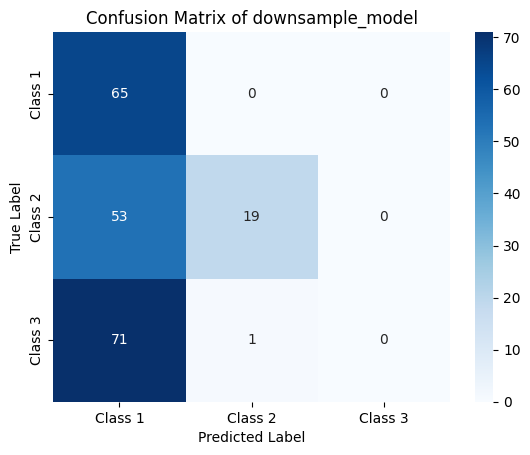

In [138]:

downsample_model = make_model(space_params, best_params_downsampled)
downsample_model.fit(X_train_d, y_train_d, epochs=5, batch_size=space_params['mini_batch_size'][best_params_downsampled['mini_batch_size']], validation_data=(X_val_d, y_val_d), verbose=0)
confusion_matrix_on_test_data(downsample_model, 'downsample_model', X_test_d, y_test_d)

  1/132 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step
  5/132 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step  
  9/132 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
 13/132 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
 17/132 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
 22/132 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
 26/132 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
 30/132 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
 34/132 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
 38/132 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
 43/132 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
 47/132 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
 51/132 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
 55/132 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
 59/132 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
 63/132 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
 67/132 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
 71/132 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
 75/132 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
 79/132 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
 83/132 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
 87/132 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
 91/132 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
 95/132 ━━━━━━━━━━━━━━━━━━━━ 0

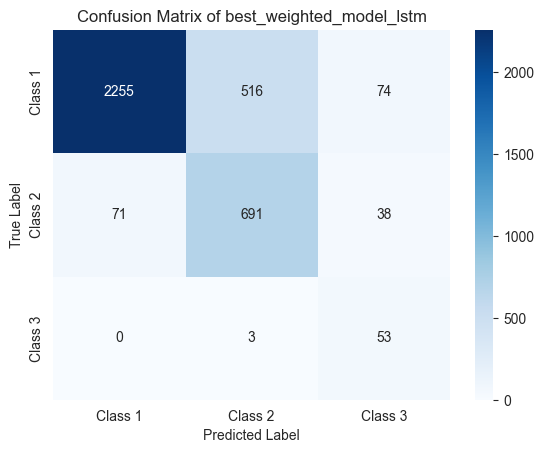

In [6]:
def make_model_lstm(space,best_params):
    Input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    model= tf.keras.models.Sequential([
        Input_layer,
        # filters, kernel_size, activation, input_shape
        tf.keras.layers.Conv1D(space['conv_filters_1'][best_params['conv_filters_1']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        # window size
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_2'][best_params['conv_filters_2']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_3'][best_params['conv_filters_3']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_4'][best_params['conv_filters_4']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.LSTM(space['neurons_lstm'][best_params['neurons_lstm']]),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=space['learning_rate'][best_params['learning_rate']]), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    return model
    
def objective_weighted_lstm(params):
    Input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    model= tf.keras.models.Sequential([
        Input_layer,
        tf.keras.layers.Conv1D(params['conv_filters_1'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_2'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_3'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_4'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.LSTM(params['neurons_lstm']),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    model.fit(X_train, y_train, epochs=50, batch_size=params['mini_batch_size'], validation_data=(X_val, y_val), verbose=0, class_weight=class_weight)
    # _, val_acc = model.evaluate(X_val, y_val, verbose=0)
    recall = recall_score(y_val, model.predict(X_val,verbose=0).argmax(axis=1), average='macro')
    return -recall  # Hyperopt minimizes the objective function

trials = Trials()
best_params_weighted_lstm = fmin(objective_weighted_lstm, space, algo=tpe.suggest, max_evals=5, trials=trials)
print("Best hyperparameters:", best_params_weighted_lstm)

best_weighted_model_lstm = make_model_lstm(space_params, best_params_weighted_lstm)
best_weighted_model_lstm.fit(X_train, y_train, epochs=50, batch_size=space_params['mini_batch_size'][best_params_weighted_lstm['mini_batch_size']], validation_data=(X_val, y_val), verbose=0, class_weight=class_weight)
confusion_matrix_on_test_data(best_weighted_model_lstm, 'best_weighted_model_lstm', X_test, y_test)    

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step
  4/132 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step  
  7/132 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
 10/132 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
 13/132 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
 16/132 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
 19/132 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
 22/132 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
 25/132 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
 28/132 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
 31/132 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
 34/132 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
 37/132 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
 40/132 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
 43/132 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
 46/132 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
 49/132 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
 52/132 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
 55/132 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
 58/132 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
 61/132 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
 64/132 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
 67/132 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
 70/132 ━━━━━━━━━━━━━━━━━━━━ 1

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step                 
  6/132 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step  
 11/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 16/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 21/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 26/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 31/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 36/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 41/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 46/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 51/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 56/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 61/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 66/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 71/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 76/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 81/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 86/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 91/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 96/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
101/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
106/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
111/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
116/132 ━━━━━

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step              
  4/132 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step  
  7/132 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
 10/132 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
 13/132 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
 16/132 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
 19/132 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
 22/132 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
 25/132 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
 28/132 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
 31/132 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
 34/132 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 37/132 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 40/132 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 43/132 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 46/132 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 49/132 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 52/132 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 55/132 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 58/132 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 61/132 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 64/132 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 67/132 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 70/132 ━━━━━━━━

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step                
  6/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step  
 12/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
 18/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
 24/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
 29/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
 35/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 41/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 47/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 53/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 58/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 64/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 70/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 76/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 82/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 88/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 94/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
100/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
106/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
111/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
116/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
121/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
127/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
132/132 ━━━━━━

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step              
  4/132 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step  
  7/132 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
 10/132 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
 13/132 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
 16/132 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
 19/132 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
 22/132 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
 25/132 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
 28/132 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
 31/132 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
 34/132 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
 36/132 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
 39/132 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
 42/132 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
 45/132 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
 48/132 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
 51/132 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
 54/132 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
 57/132 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
 60/132 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
 63/132 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
 66/132 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
 69/132 ━━━━━━━━

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step              
  6/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step  
 12/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
 18/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
 24/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
 30/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
 36/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 41/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 46/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 52/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 58/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 64/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 69/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 75/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 81/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 86/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 91/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 97/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
103/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
109/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
115/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
121/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
127/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
132/132 ━━━━━━━━

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step              
  7/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step   
 13/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
 19/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
 25/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 31/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 37/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 44/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 50/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 56/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 62/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 68/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 74/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 80/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 86/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 92/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 98/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
104/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
110/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
116/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
122/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
128/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/s

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step              
  6/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step  
 11/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 16/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 21/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 26/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 31/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 36/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 41/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 46/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 51/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 56/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 61/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 66/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 71/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 76/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 81/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 86/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 91/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 96/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
101/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
106/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
111/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
116/132 ━━━━━━━━

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step              
  9/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step   
 17/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 25/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 34/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 42/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 50/132 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 59/132 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 68/132 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 76/132 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 84/132 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 92/132 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
100/132 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
108/132 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
116/132 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
124/132 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

 30%|███       | 9/30 [18:14<37:13, 106.36s/trial, best loss: -0.7040456249953005]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step              
  8/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step   
 15/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 23/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 31/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 38/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 45/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 52/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 59/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 67/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 75/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 83/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 91/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 99/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
106/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
113/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
120/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
128/132 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

 33%|███▎      | 10/30 [19:46<34:02, 102.14s/trial, best loss: -0.7040456249953005]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step               
  3/132 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step  
  6/132 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
  9/132 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
 12/132 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
 15/132 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
 18/132 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
 21/132 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
 24/132 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
 27/132 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
 30/132 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
 33/132 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 36/132 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 39/132 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 42/132 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 45/132 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 48/132 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 51/132 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 54/132 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
 57/132 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
 60/132 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
 63/132 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
 66/132 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
 69/132 ━━━━━━━

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step               
  5/132 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step  
  9/132 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
 13/132 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
 17/132 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
 21/132 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
 25/132 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
 29/132 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
 33/132 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
 37/132 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
 41/132 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
 45/132 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
 49/132 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
 53/132 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
 57/132 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
 61/132 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
 65/132 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
 69/132 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
 73/132 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
 77/132 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
 81/132 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
 85/132 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
 89/132 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
 93/132 ━━━━━━━

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step               
  6/132 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step  
 11/132 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
 16/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 21/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 26/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 31/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 36/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 41/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 46/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 51/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 56/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 61/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 66/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 71/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 76/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 81/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 86/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 91/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 96/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
101/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
106/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
111/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
116/132 ━━━━━━━

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step               
  6/132 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step  
 11/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 16/132 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
 21/132 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
 26/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 31/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 36/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 41/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 46/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 50/132 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
 54/132 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
 58/132 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
 63/132 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
 67/132 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
 70/132 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
 73/132 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
 76/132 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
 80/132 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
 83/132 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
 86/132 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
 90/132 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
 94/132 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
 98/132 ━━━━━━━

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step               
  6/132 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step  
 11/132 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
 16/132 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
 21/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 27/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 32/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 38/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 44/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 49/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 54/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 59/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 64/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 69/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 75/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 80/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 86/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 91/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 97/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
103/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
109/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
114/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
120/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
125/132 ━━━━━━━

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step               
 10/132 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step   
 20/132 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 29/132 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 39/132 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 50/132 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 61/132 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 71/132 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 81/132 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 91/132 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
102/132 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
112/132 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
122/132 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

 53%|█████▎    | 16/30 [31:13<22:35, 96.83s/trial, best loss: -0.7040456249953005] 

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step              
 11/132 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step   
 22/132 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 34/132 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 46/132 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 58/132 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 69/132 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 80/132 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 91/132 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
103/132 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
114/132 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
125/132 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

 57%|█████▋    | 17/30 [31:54<17:20, 80.06s/trial, best loss: -0.7040456249953005]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step              
  4/132 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step  
  7/132 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
 10/132 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
 14/132 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
 18/132 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
 22/132 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
 25/132 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
 28/132 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
 31/132 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
 33/132 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
 36/132 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 39/132 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 42/132 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 45/132 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 48/132 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 51/132 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 55/132 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 58/132 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 62/132 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
 65/132 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
 68/132 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
 71/132 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
 73/132 ━━━━━━━━

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step               
  4/132 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step  
  7/132 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
 10/132 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
 13/132 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
 15/132 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
 18/132 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
 21/132 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
 24/132 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
 27/132 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
 30/132 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
 33/132 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
 36/132 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
 39/132 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
 42/132 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
 45/132 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
 48/132 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
 51/132 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
 54/132 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
 57/132 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
 60/132 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
 63/132 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
 66/132 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
 69/132 ━━━━━━━

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step               
  7/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step  
 13/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 
 19/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
 25/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 31/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 37/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 43/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 49/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 55/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 61/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 67/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 73/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 79/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 85/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 91/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 97/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
103/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
109/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
115/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
121/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
127/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 22s 173ms/step               
  7/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step  
 13/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 
 19/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
 25/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
 31/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
 37/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 43/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 49/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 55/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 61/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 67/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 73/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 79/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 85/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 91/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 96/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
102/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
105/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
110/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
116/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
121/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
124/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
130/132 ━━━━━━━━━━━━━━━━━━━

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step               
  7/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step   
 13/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
 19/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
 25/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 31/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 37/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 43/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 49/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 55/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 61/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 67/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 73/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 79/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 85/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 91/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 97/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
103/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
109/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
114/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
119/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
125/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step               
  6/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step  
 12/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
 18/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
 24/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
 30/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 36/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
 42/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 49/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 56/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 63/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 70/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 77/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 83/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 90/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 97/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
104/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
109/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
114/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
120/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
125/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
130/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 1

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step               
  6/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step  
 12/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
 17/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
 23/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
 29/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
 35/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 41/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 47/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 52/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 57/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 62/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 68/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 74/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 80/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 86/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 91/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 97/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
102/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
107/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
112/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
117/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
121/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
126/132 ━━━━━━━

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step               
  7/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step   
 13/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
 19/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 25/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 31/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 37/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 43/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 49/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 55/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 61/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 67/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 73/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 79/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 85/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 91/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 97/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
103/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
109/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
115/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
121/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
127/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10m

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step               
  8/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step   
 15/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
 22/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
 29/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
 36/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
 43/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
 50/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
 57/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
 64/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
 71/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
 78/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
 85/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
 92/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
 99/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
106/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
113/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
120/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
127/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

 87%|████████▋ | 26/30 [49:58<06:47, 101.78s/trial, best loss: -0.7040456249953005]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step               
  7/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step   
 14/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
 20/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 26/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 32/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 37/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 43/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 49/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 55/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 61/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 67/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 73/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 79/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 84/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 90/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 96/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
102/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
108/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
114/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
120/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
127/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10m

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step               
  6/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step  
 12/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
 17/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
 22/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
 27/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
 32/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
 37/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 42/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 47/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 52/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 57/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 62/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 67/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 72/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 77/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 82/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 87/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 92/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 97/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
102/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
107/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
112/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
117/132 ━━━━━━━

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step               
  7/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step   
 14/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
 21/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
 27/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
 34/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
 41/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
 48/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
 54/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
 61/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
 67/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
 74/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
 81/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
 87/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
 94/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
101/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
107/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
113/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
119/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
125/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

 97%|█████████▋| 29/30 [54:48<01:36

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/132 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step              
  6/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step  
 12/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
 17/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
 22/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
 27/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
 32/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
 37/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 42/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 47/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 52/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 57/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 62/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 67/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 72/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 77/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 82/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 87/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 92/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
 97/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
102/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
107/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
112/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
117/132 ━━━━━━━━

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


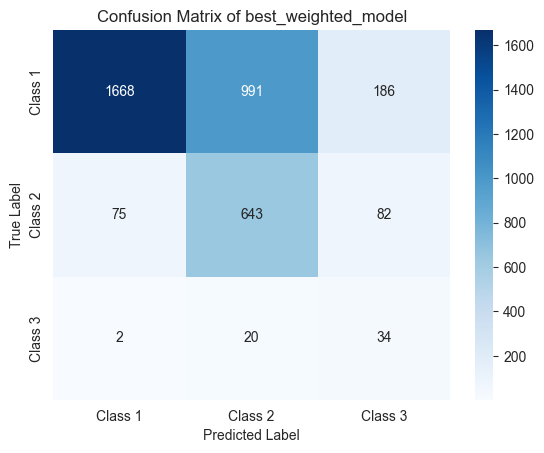

In [9]:
def make_model_gru(space,best_params):
    Input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    model= tf.keras.models.Sequential([
        Input_layer,
        # filters, kernel_size, activation, input_shape
        tf.keras.layers.Conv1D(space['conv_filters_1'][best_params['conv_filters_1']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        # window size
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_2'][best_params['conv_filters_2']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_3'][best_params['conv_filters_3']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_4'][best_params['conv_filters_4']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.GRU(space['neurons_gru'][best_params['neurons_gru']]),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=space['learning_rate'][best_params['learning_rate']]), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    return model
    
def objective_weighted_gru(params):
    Input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    model= tf.keras.models.Sequential([
        Input_layer,
        tf.keras.layers.Conv1D(params['conv_filters_1'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_2'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_3'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_4'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.LSTM(params['neurons_gru']),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    model.fit(X_train, y_train, epochs=50, batch_size=params['mini_batch_size'], validation_data=(X_val, y_val), verbose=0, class_weight=class_weight)
    # _, val_acc = model.evaluate(X_val, y_val, verbose=0)
    recall = recall_score(y_val, model.predict(X_val).argmax(axis=1), average='macro')
    return -recall  # Hyperopt minimizes the objective fu
    

trials = Trials()
best_params_weighted_gru = fmin(objective_weighted_gru, space, algo=tpe.suggest, max_evals=5, trials=trials)

print("Best hyperparameters:", best_params_weighted_gru)
best_weighted_model_gru = make_model_gru(space_params, best_params_weighted_gru)
best_weighted_model_gru.fit(X_train, y_train, epochs=50, batch_size=space_params['mini_batch_size'][best_params_weighted_gru['mini_batch_size']], validation_data=(X_val, y_val), verbose=0, class_weight=class_weight)
confusion_matrix_on_test_data(best_weighted_model_gru, 'best_weighted_model', X_test, y_test)    